In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pickle
from scipy.stats import norm
import pickle
from sklearn.utils import shuffle

In [3]:
cd .. 

/home/rd804/m-anode


In [4]:
with open('data/data.pkl','rb') as f:
    data = pickle.load(f)

sig_train = 1
x_train = data[str(sig_train)]['train']['data']

In [5]:
import torch
import math

# define custom pytorch loss
def negative_log_likelihood(model,X):
    output = model(X)
    
    return -torch.sum(torch.log(output))



AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [ ]:
class Gaussian(torch.nn.Module):
    def __init__(self, x):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.mu1 = torch.nn.Parameter(
            torch.torch.distributions.Uniform(low=torch.min(x), 
                                              high=torch.max(x)).sample())
       # self.mu2 = torch.nn.Parameter(torch.randn(()))
        self.sigma1 = torch.nn.Parameter(
            torch.torch.distributions.Uniform(low=0, 
                                              high=(torch.max(x)-torch.min(x))).sample())
       # self.sigma2 = torch.nn.Parameter(torch.randn(()))
       # self.w = torch.nn.Parameter(torch.randn(()))




    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return torch.exp(-0.5 * (x - self.mu1) ** 2 / self.sigma1 ** 2) / (self.sigma1 * math.sqrt(2 * math.pi))

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = exp(-0.5 * (x - {self.mu1.item()}) ** 2 / {self.sigma1.item()} ** 2) / ({self.sigma1.item()} * math.sqrt(2 * math.pi))'
    
    def return_parameters(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return {'mu1' : self.mu1.detach().item(),
                'sigma1': self.sigma1.detach().item()}


# Create Tensors to hold input and outputs.
x = torch.torch.distributions.Normal(loc=5, scale=5).sample((10000,))

# Construct our model by instantiating the class defined above
model = Gaussian(x)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined
# with torch.nn.Parameter) which are members of the model.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
for t in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = negative_log_likelihood(model, x)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Result: {model.string()}')

Result: y = exp(-0.5 * (x - 4.992231845855713) ** 2 / 5.0321574211120605 ** 2) / (5.0321574211120605 * math.sqrt(2 * math.pi))


In [ ]:
model.return_parameters()

{'mu1': 4.992231845855713, 'sigma1': 5.0321574211120605}

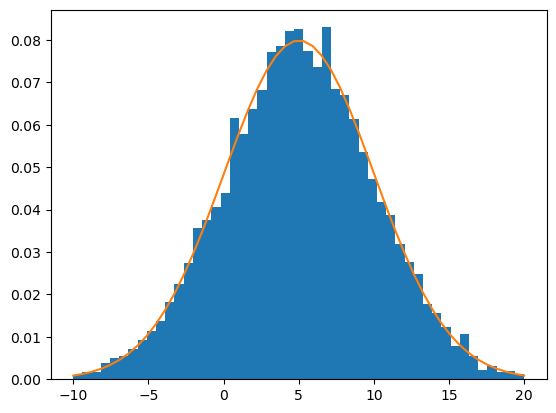

In [ ]:
bins = np.linspace(-10, 20, 50)
density = model(torch.from_numpy(bins).float()).detach().numpy()

plt.hist(x.detach().numpy(), bins=bins, density=True)
plt.plot(bins, density, label='Estimated')
plt.show()

In [6]:
def inverse_sigmoid(x):
    return torch.log(x/(1-x))

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

x = torch.tensor([0.5])
print(sigmoid(inverse_sigmoid(x)))
print(inverse_sigmoid(sigmoid(x)))
print(sigmoid(x))

tensor([0.5000])
tensor([0.5000])
tensor([0.6225])


In [210]:
def p_theta_given_x(x, mu, sigma, w):
    p_theta1 = w[0] * torch.exp(-0.5 * (x - mu[0]) ** 2 / sigma[0] ** 2) / (sigma[0] * math.sqrt(2 * math.pi))
    p_theta2 = w[1] * torch.exp(-0.5 * (x - mu[1]) ** 2 / sigma[1] ** 2) / (sigma[1] * math.sqrt(2 * math.pi))

    prior_1 = torch.mean(p_theta1/(p_theta1+p_theta2)).detach().numpy().item()
    prior_2 = torch.mean(p_theta2/(p_theta1+p_theta2)).detach().numpy().item()


    return torch.nn.Parameter(torch.Tensor([prior_1, prior_2]), requires_grad=False)

In [35]:
# Create Tensors to hold input and outputs.
x_1 = torch.torch.distributions.Normal(loc=0, scale=3).sample((100000,))
x_2 = torch.torch.distributions.Normal(loc=10, scale=3).sample((100000,))
x = torch.concatenate((x_1, x_2))

x = shuffle(x)

In [57]:
class Gaussian_2(torch.nn.Module):
    def __init__(self, x, n_components=2):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()

        _w = inverse_sigmoid(torch.Tensor([1/n_components]))
        self.w = torch.nn.Parameter(_w)
    #    self.mu = torch.nn.Parameter(torch.Tensor([0.0,10]))
     #   self.sigma = torch.nn.Parameter(torch.Tensor([3.0,3.0]))
        self.mu = [torch.nn.Parameter(
            torch.torch.distributions.Uniform(low=torch.min(x), 
                                             high=torch.max(x)).sample()) for i in range(n_components)]
        self.sigma = [torch.nn.Parameter(
            torch.torch.distributions.Uniform(low=0, 
                                              high=(torch.max(x)-torch.min(x))).sample()) for i in range(n_components)]
 



    def forward(self, x):

        n = len(self.mu)

        p = 0

        for i in range(n):
            if i == 0:
                p = sigmoid(self.w[0]) * torch.exp(-0.5 * (x - self.mu[i]) ** 2 / self.sigma[i] ** 2) / (self.sigma[i] * math.sqrt(2 * math.pi))
            else:
                p += (1-sigmoid(self.w[0])) * torch.exp(-0.5 * (x - self.mu[i]) ** 2 / self.sigma[i] ** 2) / (self.sigma[i] * math.sqrt(2 * math.pi))
        return p

    def string(self):

        w = sigmoid(self.w)
        return f'y = {(w[0]).item()} * Gaussian(x, {self.mu[0].item()}, {self.sigma[0].item()}) + \
            {1-(w[0]).item()} * Gaussian(x, {self.mu[1].item()}, {self.sigma[1].item()})'
    
    def return_parameters(self):

        return {'mu 1' : self.mu[0].detach().item(),
                'sigma 1': self.sigma[0].detach().item(),
                'mu 2' : self.mu[1].detach().item(),
                'sigma 2': self.sigma[1].detach().item(),
                'w': sigmoid(self.w[0]).detach().item()}



# Construct our model by instantiating the class defined above
model = Gaussian_2(x)

likelihood = []

batch_size = 32
n_batches = len(x) // batch_size

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined
# with torch.nn.Parameter) which are members of the model.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


for t in range(50):
    print(f'Epoch {t}')
    # Forward pass: Compute predicted y by passing x to the model
    likelihood_epoch = 0

    for i in range(n_batches):
        x_batch = x[i*batch_size:(i+1)*batch_size]
        y_pred = model(x_batch)

        # Compute and print loss
        loss = negative_log_likelihood(model, x_batch)

        likelihood_epoch += loss.item()

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   # model.update_w(x)
    likelihood.append(likelihood_epoch)


print(f'Result: {model.string()}')

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Result: y = 3.272704102077334e-13 * Gaussian(x, -11.379962921142578, 5.916412353515625) +             0.9999999999996727 * Gaussian(x, 15.479469299316406, 12.48890495300293)


In [58]:
model.return_parameters()

{'mu 1': -11.379962921142578,
 'sigma 1': 5.916412353515625,
 'mu 2': 15.479469299316406,
 'sigma 2': 12.48890495300293,
 'w': 3.272704102077334e-13}

'torch.FloatTensor'

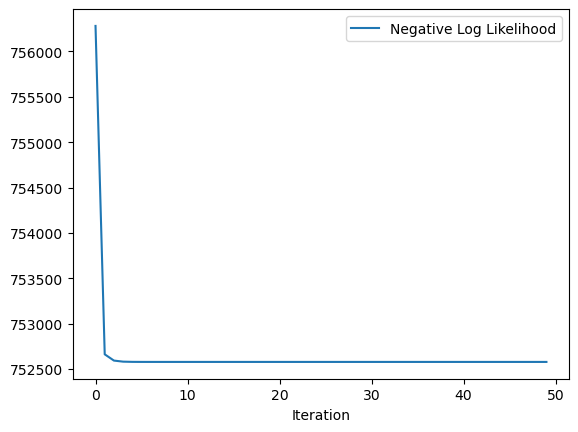

In [55]:
plt.plot(likelihood, label='Negative Log Likelihood')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [47]:
likelihood[-4]

852787.8607788086

In [38]:
model.return_parameters()

{'mu 1': 20.790252685546875,
 'sigma 1': 12.240732192993164,
 'mu 2': 19.51986312866211,
 'sigma 2': 11.816057205200195,
 'w': 1.835939576365006e-13}

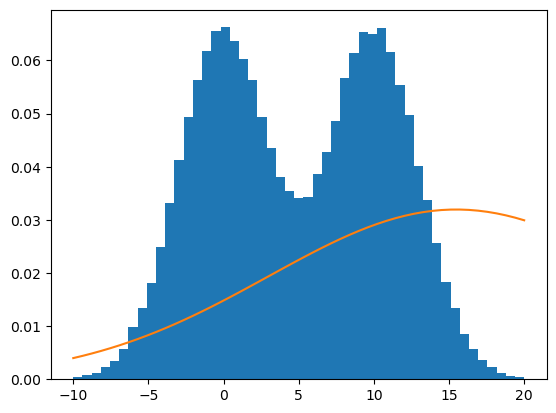

In [59]:
bins = np.linspace(-10, 20, 50)
density = model(torch.from_numpy(bins).float()).detach().numpy()

plt.hist(x.detach().numpy(), bins=bins, density=True)
plt.plot(bins, density, label='Estimated')

#plt.plot(bins, model(torch.from_numpy(bins).float()).detach().numpy(), label='Estimated')
plt.show()

In [ ]:
# use pytorch to optimize the negative likelihood

# define the optimizer





    

tensor([0.1023, 0.1010, 0.0534,  ..., 0.0624, 0.0446, 0.0775],
       dtype=torch.float64, requires_grad=True)

In [242]:
import numbers


def tensor(arr, dtype=torch.DoubleTensor):
    """
    Converts a float or an (numpy) array to a torch tensor.
    Parameters
    ----------
    arr :   float or list or ndarray
            Scalar or array of floats
    dtype : torch.dtype

    Returns
    -------
    Torch Tensor
    """
    if isinstance(arr, numbers.Number):
        t = torch.ones(1)*arr
    elif type(arr) is list or type(arr) is tuple:
        t = torch.Tensor(arr)
    else:
        t = torch.from_numpy(np.array(arr))
    return t.type(dtype)

In [243]:
class Normal(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, *args):
        x = args[0]
        mean = self.mean.expand(x.size())
        var = self.std.expand(x.size()) ** 2
        p = 1./torch.sqrt(2.0*np.pi*var) * torch.exp(- ((x-mean)**2) / (2.0 * var))
        return p

In [244]:
import numpy as np
import torch
from torch.autograd import Variable

def fit(pdfs, parameters, observations, iter, lr):
    """Estimates the parameters of a mixture model via maximum likelihood maximization.
    Uses gradient descent for optimization.


    Parameters
    ----------
    pdfs :          List of callable pdfs
                    Callable probability density functions (likelihood function)
                    expecting an array of observations as the only argument.
    parameters :    List of list
                    List of list of parameters that are subject to optimization.
                    e.g. for a bimodal gaussian mixture: [[mu_1, sigma_1], [mu_2, sigma_2]]
    observations :  ndarray
                    Observations from an unknown pdf which parameters are subject to be estimated
    iter :          float
                    Maximum number of iterations
    lr :            float
                    Gradient descent learning rate

    Returns
    -------

    """

    # number of models/classes in mixture
    K = len(parameters)

    # initialize mixing coefficients with random values
    mixcoeffs = np.random.rand(K)
    mixcoeffs /= np.sum(mixcoeffs)

    # make the coefficients visible to the update step
    for k in range(K):
        mixcoeff = Variable(tensor(mixcoeffs[k]), requires_grad=True)
        parameters[k].append(mixcoeff)

    for i in range(iter):
        likelihood = 0
        for k in range(K):
            # multiply the likelihood with the mixing coefficients
            #  mixing coefficient: p(z_k = 1)
            p_z = parameters[k][-1].expand(observations.size())
            likelihood += pdfs[k](observations) * p_z

        expectation = torch.mean(torch.log(likelihood))

        # add constraint sum(mixcoeffs) = 1 via lagrange multiplier
        for k in range(K):
            expectation -= 1.0 * parameters[k][-1]
        expectation += 1.0  # c = 1

        if np.isnan(expectation.data[0]):
            raise RuntimeError('Singular state. Try different initial parameters')

        # Determine gradients
        expectation.backward()

        # Update parameters with gradient descent
        for k in range(K):
            for param in parameters[k]:
                param.data.add_(lr * param.grad.data)
                param.grad.data.zero_()

    return expectation.data[0]


if __name__ == '__main__':
    """
    Estimate mean and std of a gaussian mixture model via MixtureModel-MLE on Kx10000 observations
    """

    np.random.seed(0)

    # number of gaussian models in mixture
    K = 2

    pdfs = []
    params = []
    true_params = []
    xs = []

    for k in range(K):
        # Sample observations from a bimodal normal distribution function with different parameter
        true_mean = np.random.uniform(-10, 10)
        true_std = np.random.uniform(0.5, 3.0)
        xs.append(true_mean + np.random.randn(np.random.randint(500, 2000)) * true_std)

        # Define likelihood function of model
        mean_estimate = Variable(tensor(true_mean+5.*np.random.randn()), requires_grad=True)
        std_estimate = Variable(tensor(1.0), requires_grad=True)

        pdfs.append(Normal(mean_estimate, std_estimate))

        params.append([mean_estimate, std_estimate])
        true_params.append([true_mean, true_std])

    x = np.concatenate(xs, axis=0)
    observations = Variable(tensor(x))

    log_likelihood = fit(pdfs, params, observations, iter=500, lr=0.1)

    print('Log likelihood: %7.5f' % log_likelihood)
    for k in range(K):
        print('k=%d mean=% 7.5f std=% 7.5f coeff=% 7.5f' % (k, params[k][0].data[0], params[k][1].data[0], params[k][2].data[0]))

    """
    Plot true and estimated distributions
    """

    import matplotlib.pyplot as plt
    n, _, _ = plt.hist(x, 100, normed=True)

    # plot distributions
    np_pdf = lambda x, mean, std: 1./np.sqrt(2.0*np.pi*std*std) * np.exp(- ((x-mean)**2) / (2.0 * std*std))
    xx = np.linspace(np.min(x), np.max(x), 1000)

    for k in range(K):
        true_y = np_pdf(xx, true_params[k][0], true_params[k][1])
        estimated_y = np_pdf(xx, params[k][0].data[0], params[k][1].data[0])

        plt.plot(xx, true_y, '-.', label='Target pdf k=%d'%(k+1))
        plt.plot(xx, estimated_y, '-', label='Estimated pdf %d' % (k+1))

    plt.legend()

    plt.show()






RuntimeError: output with shape [] doesn't match the broadcast shape [1]